 # Notebook para detecção de quebra de diálogo

In [3]:
#imports
from os.path import join as pathjoin;
from os import listdir;
import os;
import re;
import json;
import matplotlib.pyplot as plt;
import pandas as pd;
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import numpy
import sklearn.pipeline
from gensim.models import KeyedVectors
from sklearn.model_selection import GridSearchCV
import math,glob

from mlxtend.regressor import StackingRegressor
from sklearn import linear_model
from sklearn.ensemble.forest import RandomForestRegressor as RFR
from sklearn.ensemble.forest import RandomForestClassifier as RFC
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn import neural_network
import xgboost as xgb

## Bases de desenvolvimento e teste

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
base_path = '/content/gdrive/My Drive/Mestrado/Bert/Portugues/'
dev_data_path = pathjoin(base_path,'crf_baseline/train_cut')
eval_data_path = pathjoin(base_path,'crf_baseline/test_cut')

#nilcW2Vec = 'C:/Users/Leona/Dropbox/python/dbdc3/Nilc_embeddings/skip_s300.txt'
nilcW2VecZip = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip'
#word2vecGoogleNewsVectors = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
# pathjoin(base_path,'wikpedia_embeddings/word2vec-GoogleNews-vectors-master/GoogleNews-vectors-negative300.bin.gz')

In [6]:
def separateEval(originPath, destinationPath, count):
    files = listdir(originPath)
    eval_files = numpy.random.choice(files,count,False)
    if not os.path.exists(destinationPath):
        os.makedirs(destinationPath)
    for file in eval_files:
        os.rename(pathjoin(originPath,file),pathjoin(destinationPath,file))

## Separando 30% em arquivos de teste

In [ ]:
# Comentando para não correr o risco de rodar novamente
#separateEval(cic_dev_path,cic_eval_path,34)
#separateEval(iris_dev_path,iris_eval_path,30)
#separateEval(tktk_dev_path,tktk_eval_path,30)
#separateEval(yi_dev_path,yi_eval_path,30)

### Funções úteis

In [7]:
def loadConversations(path):
    conversations = []
    for f in listdir(path):
        if '.log.json' in f:
            json_obj = json.load(open(pathjoin(path,f), encoding='utf-8'))
            json_obj['file_name'] = f
            conversations.append(json_obj)
    return conversations

In [8]:
def SetClass(conversations):
    for c in conversations:
        for t in c['turns']:
            t['O'] = 0
            t['T'] = 0
            t['X'] = 0
            if len(t['annotations']) == 0:
                t['X'] = 1
                t['class'] = 'O'
            else:
                t[t['annotations'][0]['breakdown']] = 1
                t['class'] = t['annotations'][0]['breakdown']
                
            #if t['speaker'] in ['Blue','SKY','DTBot','Clear Corretora']:
                #t['speaker'] = 'S'
            #else:
                #t['speaker'] = 'U'
            
            #del t['annotations']
                
    return conversations

In [9]:
# O t['class'] define o voto majoritário entre os juízes em annotations
# Geração de voto majoritário para votador humano
def SetMajorityVoteAndDistribution(conversations, threshold):
    for c in conversations:
        for t in c['turns']:
            count={}
            count['O']=0
            count['T']=0
            count['X']=0
            hasAnnotations = False
            for a in t['annotations']:
                hasAnnotations = True
                count[a['breakdown']] +=1
            del t['annotations']
            if hasAnnotations:
                #distribution
                t['O'] = count['O']*1.0 / (count['O'] + count['T'] + count['X'])
                t['T'] = count['T']*1.0 / (count['O'] + count['T'] + count['X'])
                t['X'] = count['X']*1.0 / (count['O'] + count['T'] + count['X']) 
                #majorityVoting
                t['class'] = 'O'
                t['class'] = 'X' if t['X']>=t['T'] and t['X']>=t['O'] and t['X']>=threshold else t['class']
                t['class'] = 'T' if t['T']>=t['O'] and t['T']>=t['X'] and t['T']>=threshold else t['class']
                t['class'] = 'O' if t['O']>=t['T'] and t['O']>=t['X'] and t['O']>=threshold else t['class']
                
    return conversations
        

In [10]:
def ConversationClassCount(conversations):
    count={}
    count['O']=0
    count['T']=0
    count['X']=0
    for c in conversations:
        for t in c['turns']:
            if 'class' in t:
                count[t['class']] += 1
    return count

In [11]:
def printHistogram(data,name):
    print('O = not a breakdown, T = possible breakdown, and X = breakdown')
    dataSum = ConversationClassCount(data)
    plt.hist(list(dataSum.keys()), weights=list(dataSum.values()))
    plt.title(name)
    plt.show()

In [12]:
def saveJson(outputPath, fileName, data):
    fileToSave = pathjoin(outputPath, fileName.replace('.log.json','.labels.json'))
    with open(fileToSave, 'w') as file:
        #print(data)
        file.write(json.dumps(data))

In [13]:
def outputFiles(outputPath, pipeline, test):
    test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(test)
    predictedProbas = pipeline.predict_proba(test)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        predictedValue = predictedValues[i]
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = predictedProba[1]
        label['prob-X'] = predictedProba[2] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            saveJson(outputPath, test.iloc[i]['file_name'], data)
            data = {}
            data['turns'] = []
            
        
#outputFiles(output_data_path,pipeline, test)

In [14]:
def scoreToLabel(score):
    score_float = float(score)
    if score_float<0.4:
        return 'O'
    elif score_float <0.8:
        return 'T'
    else:
        return 'X'

In [15]:
def resultArray(pipeline, test, testPred):
    #test.sort_values(['file_name', 'user-index'], ascending=[True, True])
    result ={}
    data = {}
    data['turns'] = []
    size = test.shape[0]
    predictedValues = pipeline.predict(testPred)
    predictedProbas = pipeline.predict_proba(testPred)
    for i in range(size):
        data['dialogue-id'] = test.iloc[i]['dialogue-id']
        result[data['dialogue-id']] = data
        predictedValue = scoreToLabel(predictedValues[i])
        predictedProba = predictedProbas[i]
        
        turn ={}
        turn['turn-index'] = int(test.iloc[i]['system-index'])
        turn['labels'] = []
        
        label ={}
        label['breakdown'] = predictedValue
        label['prob-O'] = predictedProba[0]
        label['prob-T'] = 0
        label['prob-X'] = predictedProba[1] 
        
        turn['labels'].append(label)        
        data['turns'].append(turn)
        if  i == size-1 or test.iloc[i]['file_name'] != test.iloc[i+1]['file_name']:
            data = {}
            data['turns'] = []
    return result

## Métodos de avaliação

In [16]:
def calc_distribution(annotations) :
    count_O = 0
    count_T = 0
    count_X = 0

    for annotation in annotations:
        if annotation['breakdown'] == 'O':
            count_O += 1
        elif annotation['breakdown'] == 'T':
            count_T += 1
        elif annotation['breakdown'] == 'X':
            count_X += 1

    prob_O = count_O*1.0 / (count_O + count_T + count_X)
    prob_T = count_T*1.0 / (count_O + count_T + count_X)
    prob_X = count_X*1.0 / (count_O + count_T + count_X)

    return [prob_O, prob_T, prob_X]

In [17]:
def majority_label(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T and prob_O >= prob_X and prob_O >= threshold:
        return "O"
    elif prob_T >= prob_O and prob_T >= prob_X and prob_T >= threshold:
        return "T"
    elif prob_X >= prob_T and prob_X >= prob_O and prob_X >= threshold:
        return "X"
    else:
        return "O"

In [18]:
def majority_label_lenient(prob_O, prob_T, prob_X, threshold):

    if prob_O >= prob_T + prob_X and prob_O >= threshold:
        return "O_l"
    elif prob_T + prob_X >= prob_O and prob_T + prob_X >= threshold:
        return "X_l"
    else:
        return "O_l"

In [19]:
def kld(p, q):
    k = 0.0
    for i in range(len(p)):
        if p[i] > 0:
            k += p[i] * (math.log(p[i]/q[i],2))

    return k

In [20]:
def jsd(p, q):
    m = []
    for i in range(len(p)):
        m.append((p[i]+q[i])/2.0)

    return (kld(p,m) + kld(q,m)) / 2.0

In [21]:
def mse(p, q):
    total = 0.0

    for i in range(len(p)):
        total += pow(p[i] - q[i],2)

    return total / len(p)

In [22]:
def evaluation(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r")
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)

    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")

In [23]:
def evaluationAsDict(data_path,eval_data,threshold):

    file_num = 0
    label_num = 0

    correct_num = 0
    incorrect_num = 0

    predO_ansO = 0
    predO_ansT = 0
    predO_ansX = 0
    predT_ansO = 0
    predT_ansT = 0
    predT_ansX = 0
    predX_ansO = 0
    predX_ansT = 0
    predX_ansX = 0

    predO_ansO_l = 0
    predO_ansX_l = 0
    predT_ansO_l = 0
    predT_ansX_l = 0
    predX_ansO_l = 0
    predX_ansX_l = 0

    jsd_O_T_X_sum = 0.0
    jsd_O_TX_sum = 0.0
    jsd_OT_X_sum = 0.0
    mse_O_T_X_sum = 0.0
    mse_O_TX_sum = 0.0
    mse_OT_X_sum = 0.0

    pred_dist_list = []
    ans_dist_list = []

    #parser = argparse.ArgumentParser()
    #parser.add_argument('-p', dest='datapath', action='store', metavar='TESTDIR', required=True,
                        #help='テスト用の対話データが入ったディレクトリ')
    #parser.add_argument('-o', dest='evalpath', action='store', metavar='EVALDIR', required=True,
                        #help='評価用データが入ったディレクトリ')
    #parser.add_argument('-t', dest='threshold', action='store', metavar='THRESHOLD', required=False,
                        #help='正解ラベルを決定するためのしきい値')

    #args = parser.parse_args()

    #data_path = args.datapath
    #eval_path = args.evalpath

    #threshold = 0.0
    #if args.threshold != None:
    #    threshold = float(args.threshold)

    #if not data_path.endswith('/') or not data_path.endswith('\\'):
        #data_path += '/'
    #if not eval_path.endswith('/') or not eval_path.endswith('\\'):
        #eval_path += '/'

    data_files = glob.glob(data_path + '/*log.json')
    
    for f in data_files:
    #for data_json in data_files:
        file_num += 1

        data_fp = open(f, "r", encoding='utf-8')
        data_json = json.load(data_fp)
        data_fp.close()

        dlg_id = data_json["dialogue-id"]
        #eval_fp = open(eval_path + dlg_id + ".labels.json", "r")
        #eval_json = json.load(eval_fp)
        #eval_fp.close()
        
        eval_json = eval_data[dlg_id]
        #print(dlg_id)
        eval_index = 0
        for turn in data_json['turns']:
            if turn['speaker'] == "U" or turn['annotations']==[]:  # modified Sep 17 2017
                continue

            label_num += 1

            ans_prob_dist = calc_distribution(turn['annotations'])
            ans_dist_list.append(ans_prob_dist)
            ans_label = majority_label(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            ans_label_l = majority_label_lenient(ans_prob_dist[0], ans_prob_dist[1], ans_prob_dist[2], threshold)

            #print(f)
            target_label = eval_json['turns'][eval_index]['labels'][0]
            
            #print(str(ans_label)+','+str(target_label['breakdown'])+','+ str(turn['turn-index'])+','+ str(eval_json['turns'][eval_index]['turn-index']))

            pred_prob_dist = [float(target_label['prob-O']), float(target_label['prob-T']), float(target_label['prob-X'])]
            pred_dist_list.append(pred_prob_dist)

            jsd_O_T_X_sum += jsd(ans_prob_dist,pred_prob_dist)
            jsd_O_TX_sum += jsd([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            jsd_OT_X_sum += jsd([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            mse_O_T_X_sum += mse(ans_prob_dist,pred_prob_dist)
            mse_O_TX_sum += mse([ans_prob_dist[0],ans_prob_dist[1] + ans_prob_dist[2]],[pred_prob_dist[0],pred_prob_dist[1] + pred_prob_dist[2]])
            mse_OT_X_sum += mse([ans_prob_dist[0] + ans_prob_dist[1],ans_prob_dist[2]],[pred_prob_dist[0] + pred_prob_dist[1] ,pred_prob_dist[2]])

            pred_label = target_label['breakdown']
            eval_index += 1

            if pred_label == ans_label:
                correct_num += 1
            else:
                incorrect_num += 1

            if pred_label == "O":
                if ans_label == "O":
                    predO_ansO += 1
                elif ans_label == "T":
                    predO_ansT += 1
                elif ans_label == "X":
                    predO_ansX += 1
            elif pred_label == "T":
                if ans_label == "O":
                    predT_ansO += 1
                elif ans_label == "T":
                    predT_ansT += 1
                elif ans_label == "X":
                    predT_ansX += 1
            elif pred_label == "X":
                if ans_label == "O":
                    predX_ansO += 1
                elif ans_label == "T":
                    predX_ansT += 1
                elif ans_label == "X":
                    predX_ansX += 1

            #lenient
            if pred_label == "O":
                if ans_label_l == "O_l":
                    predO_ansO_l += 1
                elif ans_label_l == "X_l":
                    predO_ansX_l += 1
            elif pred_label == "T":
                if ans_label_l == "O_l":
                    predT_ansO_l += 1
                elif ans_label_l == "X_l":
                    predT_ansX_l += 1
            elif pred_label == "X":
                if ans_label_l == "O_l":
                    predX_ansO_l += 1
                elif ans_label_l == "X_l":
                    predX_ansX_l += 1


#     print correct_num
#     print incorrect_num
#
#     print predO_ansO
#     print predO_ansT
#     print predO_ansX
#     print predT_ansO
#     print predT_ansT
#     print predT_ansX
#     print predX_ansO
#     print predX_ansT
#     print predX_ansX


    #print str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l + predO_ansX_l + predO_ansO_l)
    
    print("######### Data Stats #########")
    print("File Num : \t\t" + str(file_num))
    print("System Utterance Num : \t" + str(label_num))
    print("O Label Num : \t\t" + str(predO_ansO + predT_ansO + predX_ansO))
    print("T Label Num : \t\t" + str(predO_ansT + predT_ansT + predX_ansT))
    print("X Label Num : \t\t" + str(predO_ansX + predT_ansX + predX_ansX))
    print("")

    print("######### Results #########")
    print("Accuracy : \t\t%4f" % ((correct_num*1.0) / (correct_num + incorrect_num)) + " (" + str(correct_num) + "/" + str(correct_num + incorrect_num) + ")\n")

    precision_s = 0.0
    recall_s = 0.0
    fmeasure_s = 0.0

    if predX_ansX > 0:
        if (predX_ansO + predX_ansT + predX_ansX) > 0:
            precision_s = predX_ansX*1.0 / (predX_ansO + predX_ansT + predX_ansX)
        if (predO_ansX + predT_ansX + predX_ansX) > 0:
            recall_s = predX_ansX*1.0 / (predO_ansX + predT_ansX + predX_ansX)

    if precision_s > 0 and recall_s > 0:
        fmeasure_s = (2*precision_s*recall_s)/(precision_s + recall_s)

    print("Precision (X) : \t%4f" % (precision_s) + " (" + str(predX_ansX) + "/" + str(predX_ansO + predX_ansT + predX_ansX) + ")")
    print("Recall    (X) : \t%4f" % (recall_s) + " (" + str(predX_ansX) + "/" + str(predO_ansX + predT_ansX + predX_ansX) + ")")
    print("F-measure (X) : \t%4f" % (fmeasure_s) + "\n")


    precision_l = 0.0
    recall_l = 0.0
    fmeasure_l = 0.0
    if (predT_ansX_l + predX_ansX_l) > 0 and (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) > 0:
        precision_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l)
    if (predT_ansX_l + predX_ansX_l) > 0 and (predO_ansX_l + predT_ansX_l + predX_ansX_l) > 0:
        recall_l = (predT_ansX_l + predX_ansX_l)*1.0 / (predO_ansX_l + predT_ansX_l + predX_ansX_l)
    if precision_l > 0 and recall_l > 0:
        fmeasure_l = (2*precision_l*recall_l)/(precision_l + recall_l)



    print("Precision (T+X) : \t%4f" % (precision_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l) + ")")
    print("Recall    (T+X) : \t%4f" % (recall_l) + " (" + str(predT_ansX_l + predX_ansX_l) + "/" + str(predO_ansX_l + predT_ansX_l + predX_ansX_l) + ")")
    print("F-measure (T+X) : \t%4f" % (fmeasure_l) + "\n")

    print("JS divergence (O,T,X) : \t%4f" % (jsd_O_T_X_sum / (correct_num + incorrect_num)))
    print("JS divergence (O,T+X) : \t%4f" % (jsd_O_TX_sum / (correct_num + incorrect_num)))
    print("JS divergence (O+T,X) : \t%4f" % (jsd_OT_X_sum / (correct_num + incorrect_num)) + "\n")

    print("Mean squared error (O,T,X) : \t%4f" % (mse_O_T_X_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O,T+X) : \t%4f" % (mse_O_TX_sum / (correct_num + incorrect_num)))
    print("Mean squared error (O+T,X) : \t%4f" % (mse_OT_X_sum / (correct_num + incorrect_num)))
    print("###########################")
    
    result_ans = {
        "fileNumber":file_num,
        "systemUtterance":label_num,
        "ansO": predO_ansO + predT_ansO + predX_ansO,
        "ansT": predO_ansT + predT_ansT + predX_ansT,
        "ansX": predO_ansX + predT_ansX + predX_ansX,
        "accuracy": ((correct_num*1.0) / (correct_num + incorrect_num)),
        "precisionX": precision_s,
        "predX_ansX":predX_ansX,
        "total_predX": predX_ansO + predX_ansT + predX_ansX,
        "total_ansX": predO_ansX + predT_ansX + predX_ansX,
        "recallX": recall_s,
        "f1X": fmeasure_s,
        
        "precisionTX":precision_l,
        "recallTX": recall_l,
        "f1TX": fmeasure_l,
        
        "totalTXAnsX": predT_ansX_l + predX_ansX_l,
        "totalPredX+PredT" : predX_ansO_l + predX_ansX_l + predT_ansO_l + predT_ansX_l,
        "totalAnsX" : predO_ansX_l + predT_ansX_l + predX_ansX_l,
        
        "js-O-T-X" : (jsd_O_T_X_sum / (correct_num + incorrect_num)),
        "js-O-T+X" : (jsd_O_TX_sum / (correct_num + incorrect_num)),
        "js-O+T-X" : (jsd_OT_X_sum / (correct_num + incorrect_num)),

        "mse-O-T-X" :  (mse_O_T_X_sum / (correct_num + incorrect_num)),
        "mse-O-T+X" :  (mse_O_TX_sum / (correct_num + incorrect_num)),
        "mse-O+T-X" :  (mse_OT_X_sum / (correct_num + incorrect_num))        
        
    }
    
    return result_ans

## Carregando Word2vec

In [26]:
 !wget 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip'
 !unzip download*.zip

--2021-01-17 00:00:20--  http://143.107.183.175:22980/download.php?file=embeddings/word2vec/skip_s300.zip
Connecting to 143.107.183.175:22980... connected.
HTTP request sent, awaiting response... 200 OK
Length: 958619745 (914M) [application/octet-stream]
Saving to: ‘download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip’

download.php?file=e 100%[===================>] 914.21M  3.99MB/s    in 2m 49s  

2021-01-17 00:03:09 (5.41 MB/s) - ‘download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip’ saved [958619745/958619745]

Archive:  download.php?file=embeddings%2Fword2vec%2Fskip_s300.zip
  inflating: skip_s300.txt           


In [27]:
w2v = KeyedVectors.load_word2vec_format('skip_s300.txt')
#w2v = KeyedVectors.load_word2vec_format(word2vecGoogleNewsVectors, binary=True)

In [28]:
# Definir um percentual de palavras que não estao nesse vocabulario
misswords = set()
def Document2Vec(text,w2v):
    tokens =  re.findall(r'\b\w+\b',text);
    missing = 0;
    count = 0;
    vector = np.array([0]*w2v.vector_size, dtype=float)
    for word in tokens:
        if word not in w2v:
            word = word.upper();
            if word not in w2v:
                word = word.lower();
                if word not in w2v:
                    word = word.capitalize();
                    if word not in w2v:
                        misswords.add(word)
                        missing += 1
                        continue
        vector = vector + w2v[word]
        count = count + 1
    if count == 0:
        return vector,  1
    return vector / count,  missing/float(len(tokens))

## Computando distribuição e voto majoritário

In [29]:
json_dev_dev = SetClass(loadConversations(dev_data_path))
json_dev_test = SetClass(loadConversations(eval_data_path))

## Histograma de cada conjunto

In [ ]:
#printHistogram(cic_data,'CIC')
#printHistogram(iris_data,'IRIS')
#printHistogram(tktk_data,'TKTK')
#printHistogram(yi_data,'YI')

## Montando o conjunto

In [30]:
def PrepareDataSet(conversations):
    items = conversations.copy()
    result = []
    for c in items:
        if c['turns'][0]['speaker']=='S':
            del c['turns'][0]
        turns_len = len(c['turns'])
        for i in range(0,turns_len,2):
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = c['turns'][i]['utterance']
                line['system-index'] = c['turns'][i+1]['turn-index']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [31]:
def GetLastNTurns(turns,index,n):
    stringToResult = turns[index]['utterance']
    while n > 0 and index > 0:
        index = index -2
        n = n-1
        stringToResult = turns[index]['utterance'] + ' '+stringToResult
    return stringToResult
    

In [32]:
def PrepareDataSetWithTail(conversations, w2v, windowSize):
    items = conversations.copy()
    result = []
    for c in items:
        #if c['turns'][0]['speaker']=='S':
            #del c['turns'][0]
        turns_len = len(c['turns'])
        userTurnTail = ''
        systemTurnTail = ''
        for i in range(0,turns_len):
            if i == 0 and c['turns'][i]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                line['user-utterance'] = ''
                line['system-utterance'] = c['turns'][i]['utterance']                
                line['user-utterance-tail'] = ''
                line['system-utterance-tail'] = c['turns'][i]['utterance']                
                line['system-index'] = c['turns'][i]['turn-index']                
                line['O'] = 1
                line['T'] = 0
                line['X'] = 0
                line['class']=0
                result.append(line)
                
            if i+1<turns_len and c['turns'][i]['speaker'] == 'U' and c['turns'][i+1]['speaker'] == 'S':
                line = {}
                line['file_name'] = c['file_name']
                line['dialogue-id'] = c['dialogue-id']
                line['user-index'] = c['turns'][i]['turn-index']
                
                #userTurnTail = userTurnTail + ' ' + c['turns'][i]['utterance']
                line['user-utterance'] = c['turns'][i]['utterance']
                
                #systemTurnTail = systemTurnTail + ' ' + c['turns'][i+1]['utterance']
                line['system-utterance'] = c['turns'][i+1]['utterance']
                
                line['user-utterance-tail'] = GetLastNTurns(c['turns'],i,windowSize)
                line['system-utterance-tail'] = GetLastNTurns(c['turns'],i+1,windowSize)
                
                line['system-index'] = c['turns'][i+1]['turn-index']                
                line['O'] = c['turns'][i+1]['O']
                line['T'] = c['turns'][i+1]['T']
                line['X'] = c['turns'][i+1]['X']
                line['classCHAR'] = c['turns'][i+1]['class']
                if c['turns'][i+1]['class'] == 'O':
                    line['class']=0
                elif c['turns'][i+1]['class'] == 'T':
                    line['class'] = 0.5
                elif c['turns'][i+1]['class'] == 'X':
                    line['class'] = 1
                else:
                    line['class'] = None
                #line['class'] = c['turns'][i+1]['class']
                result.append(line)
    return result

In [33]:
#PrepareDataSetWithTail(json_dev_dev,w2v,0)

## Transformers

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin
class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [35]:
from sklearn.base import BaseEstimator, TransformerMixin
class W2VecSelector(BaseEstimator, TransformerMixin):
    def __init__(self, w2v):
        self.w2v = w2v

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        return [Document2Vec(text,self.w2v)[0] for text in X]

In [36]:
from sklearn.base import BaseEstimator
from scipy.sparse import issparse

class DenseTransformer(BaseEstimator):
    """Convert a sparse array into a dense array."""

    def __init__(self, return_copy=True):
        self.return_copy = return_copy
        self.is_fitted = False

    def transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        if issparse(X):
            return X.toarray()
        elif self.return_copy:
            return X.copy()
        else:
            return X

    def fit(self, X, y=None):
        self.is_fitted = True
        return self

    def fit_transform(self, X, y=None):
        """ Return a dense version of the input array.
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples] (default: None)
        Returns
        ---------
        X_dense : dense version of the input X array.
        """
        return self.transform(X=X, y=y)

In [37]:
from scipy import sparse

class EmbeddingVectorizer(BaseEstimator):
    def __init__(self,norm=None,analyzer='word',min_df=1,lowercase=False,sublinear_tf=True,use_idf=True,binary=False):
        self.norm        = norm;
        self.analyzer    = analyzer;
        self.min_df      = min_df;
        self.lowercase   = lowercase;
        self.sublinear_tf= sublinear_tf;
        self.use_idf     = use_idf;
        self.binary      = binary;
        
    def fit(self, X, y=None):
        self.dim_ = len(embeddingsCache.vectors[0]);
        #self.dim_ = len(embeddingsCache[list(embeddingsCache.keys())[0]])
        self.vect = TfidfVectorizer(**self.get_params())
        self.vect.fit(X,y);
        self.word_vectors_ = np.zeros((len(self.vect.vocabulary_), self.dim_));
        
        #this arrays says if a word in the vocab has 
        self.missingWord_  = np.zeros(len(self.vect.vocabulary_),dtype=np.int8);
        
        blank = np.zeros(self.dim_);

        for  word, index in self.vect.vocabulary_.items():
            temp = blank.copy();
            for w in [word, word.lower(), word.capitalize()]:
                if w in embeddingsCache:
                    temp = embeddingsCache[w];
                    break;
            if temp.sum() == 0 :
                self.missingWord_[index] = 1;
            self.word_vectors_[index,:] = temp;
        return self
    
    def transform(self, X):
        import gc;
        gc.collect()
        X = self.vect.transform(X);
        
        X = sparse.csc_matrix(X);
        V = sparse.csc_matrix(self.word_vectors_);
        M = sparse.csc_matrix(self.missingWord_).T;
        
        #missing = (X>0).dot(M)/(X>0).sum(axis=1);
        missing = sparse.csc_matrix(missing.reshape(-1,1));
        
        #memory friendly dot product
        #X  = X.dot(V)/X.sum(axis=1);
        
        #last columns will contain the embedding coverage
        X = sparse.hstack([X,missing]);
        
        return X;
    
    def fit_transform(self, X, y=None):
        self.fit(X,y);
        return self.transform(X)
    
    def get_feature_names():
        return self.vect.get_feature_names();

In [38]:
import numpy as np
class ArrayCaster(BaseEstimator, TransformerMixin):
  def fit(self, x, y=None):
    return self

  def transform(self, data):
    return np.transpose(np.matrix(data))

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
class WindowItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key, conversationKey, windowSize):
        self.key = key
        self.conversationKey = conversationKey
        self.windowSize =windowSize

    def fit(self, x, y=None):
        return self
    
    def getLastXTurns(self,turns,index,startIndex,n):
        stringToResult = turns[index]
        while n > 0 and index > startIndex:
            index = index -1
            n = n-1
            stringToResult = turns[index] + ' '+stringToResult
        return stringToResult

    def doExecute(self,arrayTest, conversationIds, windowSize):
        newArrayTest =[]
        lastId = conversationIds[0]
        lastStartIndex = 0
        for index in range(len(arrayTest)):
            if lastId != conversationIds[index]:
                lastId = conversationIds[index]
                lastStartIndex = index
            newArrayTest.append(self.getLastXTurns(arrayTest,index,lastStartIndex,windowSize))
        return newArrayTest
        
    def transform(self, data_dict):
        return self.doExecute(data_dict[self.key], data_dict[self.conversationKey], self.windowSize)

## Monta o dataset

In [40]:
train = pd.DataFrame(PrepareDataSetWithTail(json_dev_dev,w2v,0))
test = pd.DataFrame(PrepareDataSetWithTail(json_dev_test,w2v,0))

In [ ]:
result_class_dist = {}
result_class_dist[0]=0
result_class_dist[0.5]=0
result_class_dist[1]=0
for a in train['class']:
    result_class_dist[a]=result_class_dist[a]+1
print(result_class_dist)

{0: 6809, 0.5: 0, 1: 1354}


In [ ]:
result_class_dist = {}
result_class_dist[0]=0
result_class_dist[0.5]=0
result_class_dist[1]=0
for a in test['class']:
    result_class_dist[a]=result_class_dist[a]+1
print(result_class_dist)

{0: 10085, 0.5: 0, 1: 1660}


In [ ]:
#rfr = RFR(n_estimators=500, n_jobs=2, random_state=0)
gbr = GBR(n_estimators=100, random_state=0)
xgr = xgb.XGBRegressor()
ridge = linear_model.Ridge(random_state=1)
lasso = linear_model.Lasso(random_state=1)
lr = linear_model.LinearRegression()
#mtr = RFR()  # meta regressor             
mtr = linear_model.LinearRegression()
regressors = [gbr, xgr, ridge, lasso, lr]
regressors = [gbr]
model = StackingRegressor(regressors=regressors, meta_regressor=gbr)

In [ ]:
#print(Document2Vec('queen king',w2v)[0])

In [ ]:
#print(Document2Vec('how are you',w2v)[0])

In [41]:
embeddingsCache = w2v

In [ ]:
from tqdm import tqdm

def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-utterance',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-utterance',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

N_ITER = 100

best_model = None
best_classifier = None
best_result = -np.inf
tuned_parameters = None

for i in tqdm(range(N_ITER)):
    parameters = {
        'windowSize': np.random.randint(low=3, high=11),
        'tfidf__min_df': np.random.randint(low=2, high=6),
        'tfidf__max_df': np.random.uniform(low=0.9, high=1.0),
        'gbr__n_estimators': np.random.randint(low=15, high=150),
        'gbr__learning_rate': np.random.choice(np.logspace(-3, -1, 5)),
        'gbr__max_depth': np.random.randint(low=3, high=6)
    }
    print(parameters)
    pipeline = build_pipeline(parameters)
    pipeline.fit(train, train['class'])
    
    trainPred = pipeline.predict(train)
    testPred = pipeline.predict(test)
    
    classifier = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)
    classifier.fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
    trainPred2 = classifier.predict(trainPred.reshape(-1,1))
    testPred2 = classifier.predict(testPred.reshape(-1,1))
    
    predicted = resultArray(classifier, test, testPred.reshape(-1,1))
    output = evaluationAsDict(eval_data_path,predicted,0.5)
    
    if output['f1X']>best_result:
        best_result = output['f1X']
        best_model = pipeline
        best_classifier = classifier
        tuned_parameters = parameters

print(tuned_parameters)

testPred = best_model.predict(test)
predicted = resultArray(best_classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path,predicted,0.5)

  0%|          | 0/100 [00:00<?, ?it/s]

{'windowSize': 6, 'tfidf__min_df': 4, 'tfidf__max_df': 0.9837195266866074, 'gbr__n_estimators': 46, 'gbr__learning_rate': 0.03162277660168379, 'gbr__max_depth': 5}


NameError: name 'TfidfVectorizer' is not defined

######### Data Stats #########
File Num : 		1387
System Utterance Num : 	11732
O Label Num : 		10072
T Label Num : 		0
X Label Num : 		1660

######### Results #########
Accuracy : 		0.852455 (10001/11732)

Precision (X) : 	0.485264 (1169/2409)
Recall    (X) : 	0.704217 (1169/1660)
F-measure (X) : 	0.574588

Precision (T+X) : 	0.485264 (1169/2409)
Recall    (T+X) : 	0.704217 (1169/1660)
F-measure (T+X) : 	0.574588

JS divergence (O,T,X) : 	0.135238
JS divergence (O,T+X) : 	0.135238
JS divergence (O+T,X) : 	0.135238

Mean squared error (O,T,X) : 	0.082786
Mean squared error (O,T+X) : 	0.124179
Mean squared error (O+T,X) : 	0.124179
###########################


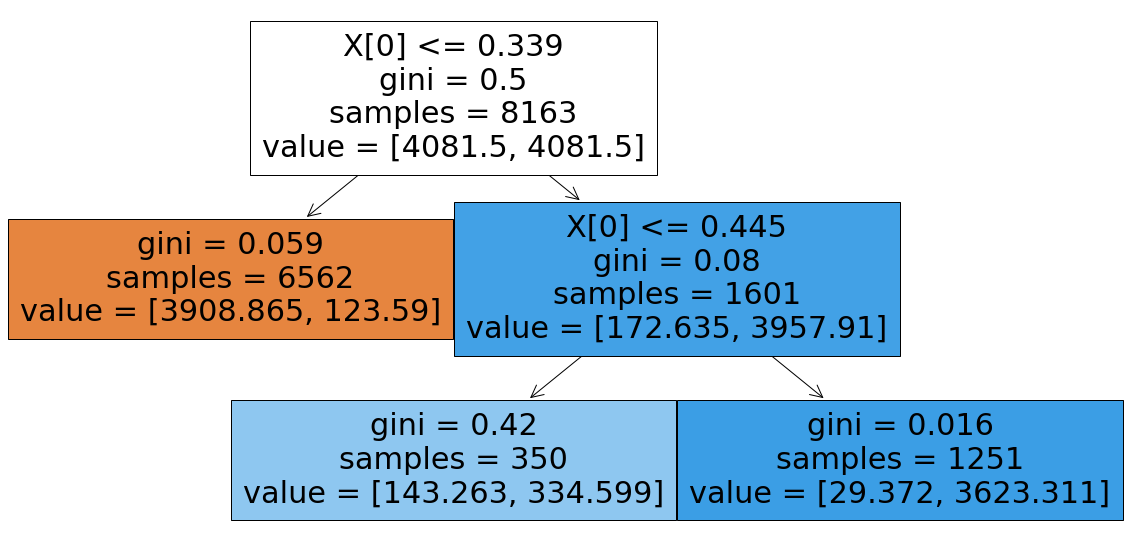

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
def build_pipeline(params):
    pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=params['tfidf__min_df'],
                                          max_df=params['tfidf__max_df'],
                                          ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999, random_state=0)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-utterance',
                                                          conversationKey='dialogue-id',
                                                          windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-utterance',
                                                            conversationKey='dialogue-id',
                                                            windowSize=params['windowSize']))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999, random_state=0))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', GBR(n_estimators=params['gbr__n_estimators'],
                learning_rate=params['gbr__learning_rate'],
                max_depth=params['gbr__max_depth'],
                random_state=0))])
    
    return pipeline


tuned_parameters = {
    'windowSize': 6,
    'tfidf__min_df': 2,
    'tfidf__max_df': 0.916702491946735,
    'gbr__n_estimators': 92,
    'gbr__learning_rate': 0.1,
    'gbr__max_depth': 5
}
pipeline = build_pipeline(tuned_parameters)

pipeline.fit(train, train['class'])

#grid = GridSearchCV(pipeline, tuned_parameters, scoring = 'neg_mean_absolute_error', n_jobs= 2)
#grid.fit(train, train['class'])


trainPred = pipeline.predict(train)
testPred = pipeline.predict(test)

classifier=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3, class_weight="balanced", random_state=0)


classifier.fit(trainPred.reshape(-1,1), train['class'].astype(str).values.reshape(-1,1))

predicted = resultArray(classifier, test, testPred.reshape(-1,1))
output = evaluationAsDict(eval_data_path, predicted, 0.5)

plt.figure(figsize=(20,10)) 
plot_tree(classifier, filled=True) 
plt.show()


In [ ]:
def saveDictionaryAsJson(outputPath, fileName, data):
    fileToSave = pathjoin(outputPath, fileName)
    with open(fileToSave, 'w') as file:
        #print(data)
        file.write(json.dumps(data))

In [ ]:
dict = {}
for p in predicted:
    for t in predicted[p]['turns']:
        dict[p + '-' + str(t['turn-index'])]= t['labels'][0]['breakdown']        

saveDictionaryAsJson('C:/Users/leona/Dropbox/python/teste_estatistico/','POR-REGw2v.json',dict)

In [ ]:
dict_test = {}
for index,row in test.iterrows():
    if not isinstance(row['classCHAR'],float):
        dict_test[row['dialogue-id']+'-'+str(row['system-index'])] = row['classCHAR']
    else:
        dict_test[row['dialogue-id']+'-'+str(row['system-index'])] = 'O'

saveDictionaryAsJson('C:/Users/leona/Dropbox/python/teste_estatistico/','POR-test.json',dict_test)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
pipeline = sklearn.pipeline.Pipeline([
    ('union', FeatureUnion(
        transformer_list=[

            ('user-utterance', Pipeline([
                ('selector', ItemSelector(key='user-utterance')),
                ('tfidf', TfidfVectorizer(min_df=2,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),

            ('system-utterance', Pipeline([
                ('selector', ItemSelector(key='system-utterance')),
                ('tfidf', TfidfVectorizer(min_df=2,ngram_range=(1,2))),
                ('sparse',DenseTransformer()),
                ('pca',PCA(0.999)),
            ])),
            
            ('user-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='user-utterance-tail'))
                ('userWindowSelector', WindowItemSelector(key='user-utterance',conversationKey='dialogue-id',windowSize=5))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),
            
            ('system-utterance-vector', Pipeline([
                #('selector', ItemSelector(key='system-utterance-tail'))
                ('systemWindowSelector', WindowItemSelector(key='system-utterance',conversationKey='dialogue-id',windowSize=5))
                ,('W2VecSelector', W2VecSelector(w2v))
                ,('pca',PCA(0.999))
                #,('W2VecSelector', EmbeddingVectorizer())
            ])),

            ('user-turn', Pipeline([
                ('selector', ItemSelector(key='user-index')),
                ('caster', ArrayCaster())
            ])),
             
            ('system-turn', Pipeline([
                ('selector', ItemSelector(key='system-index')),
                ('caster', ArrayCaster())
            ])),

        ],

        # weight components in FeatureUnion
        transformer_weights={
            'user-utterance': 1.0,
            'system-utterance': 1.0,
            'user-utterance-tail': 1.0,
            'system-utterance-tail': 1.0,
            'user-turn': 1.0,
            'system-turn':1.0,
            'kernel':'linear',
            'probability':True
        },
    )),
    ('clf', gbr)
    #('clf', model)
     #neural_network.MLPRegressor(random_state=42, max_iter=500))
    #linear_model.ElasticNetCV(random_state=42)
])

# Analisa o resultado (classification report) deste pipeline com um único regressor, dar o nome para pipelineEmbedding
# Criar outro pipeline com outra feature
# Salvar o resultado o esperado e o resultado predito de cada modelo
# output disso cria-se uma arvore de decisao como X da arvore

tuned_parameters = [{#'union__user-utterance-vector__userWindowSelector__windowSize':[5,10,15],
                     #'union__system-utterance-vector__systemWindowSelector__windowSize':[5,10,15],
                     'clf__regressors': [(rfr, ridge, lasso, lr), 
                                         (rfr, gbr, xgr)]
                    }
                   ]

In [ ]:
pipeline.fit(train, train['class'])
trainPred = pipeline.predict(train)
testPred = pipeline.predict(test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

#classifier= linear_model.LogisticRegressionCV().fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
classifier=DecisionTreeClassifier(max_depth=4, max_leaf_nodes=3).fit(trainPred.reshape(-1,1),train['class'].astype(str).values.reshape(-1,1))
trainPred2 = classifier.predict(trainPred.reshape(-1,1))
testPred2 = classifier.predict(testPred.reshape(-1,1))
testProb2 = classifier.predict(testPred.reshape(-1,1))
#print(classification_report(test['class'].astype(str).values.reshape(-1,1), testPred2.reshape(-1,1)))

In [ ]:
predicted = resultArray(classifier, test,testPred.reshape(-1,1))
evaluationAsDict(eval_data_path,predicted,0.5)

######### Data Stats #########
File Num : 		1387
System Utterance Num : 	11732
O Label Num : 		10072
T Label Num : 		0
X Label Num : 		1660

######### Results #########
Accuracy : 		0.859103 (10079/11732)

Precision (X) : 	0.502038 (862/1717)
Recall    (X) : 	0.519277 (862/1660)
F-measure (X) : 	0.510512

Precision (T+X) : 	0.502038 (862/1717)
Recall    (T+X) : 	0.519277 (862/1660)
F-measure (T+X) : 	0.510512

JS divergence (O,T,X) : 	0.126781
JS divergence (O,T+X) : 	0.126781
JS divergence (O+T,X) : 	0.126781

Mean squared error (O,T,X) : 	0.074556
Mean squared error (O,T+X) : 	0.111834
Mean squared error (O+T,X) : 	0.111834
###########################


{'fileNumber': 1387,
 'systemUtterance': 11732,
 'ansO': 10072,
 'ansT': 0,
 'ansX': 1660,
 'accuracy': 0.8591033071939993,
 'precisionX': 0.5020384391380315,
 'predX_ansX': 862,
 'total_predX': 1717,
 'total_ansX': 1660,
 'recallX': 0.519277108433735,
 'f1X': 0.5105122890139177,
 'precisionTX': 0.5020384391380315,
 'recallTX': 0.519277108433735,
 'f1TX': 0.5105122890139177,
 'totalTXAnsX': 862,
 'totalPredX+PredT': 1717,
 'totalAnsX': 1660,
 'js-O-T-X': 0.12678119223197232,
 'js-O-T+X': 0.12678119223197232,
 'js-O+T-X': 0.12678119223197232,
 'mse-O-T-X': 0.07455618115083709,
 'mse-O-T+X': 0.11183427172623514,
 'mse-O+T-X': 0.11183427172623514}

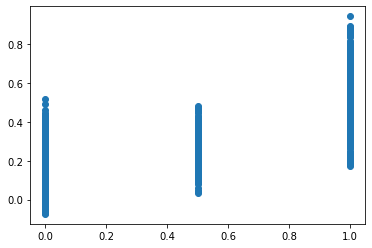

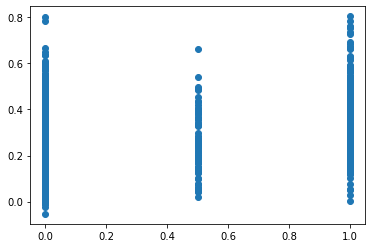

In [ ]:
plt.scatter(train['class'],trainPred);
plt.show();
plt.scatter(test['class'],testPred);
plt.show();

No handles with labels found to put in legend.


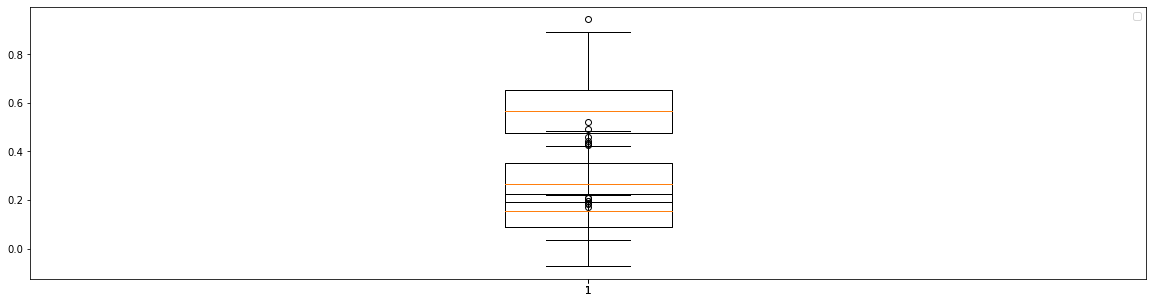

No handles with labels found to put in legend.


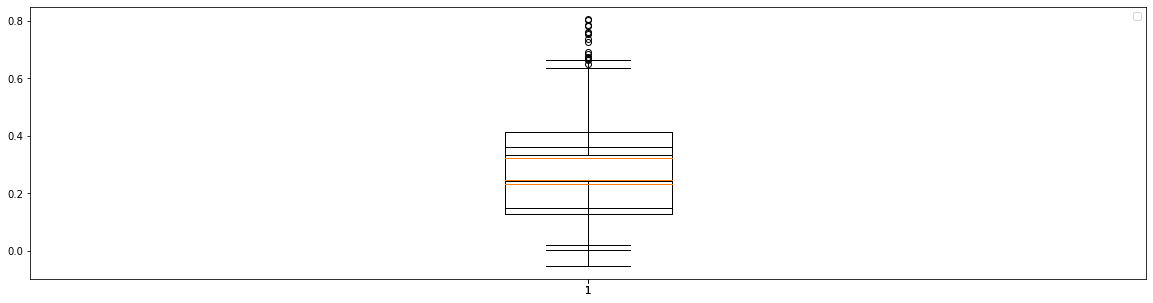

In [ ]:
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.boxplot(trainPred[train['class'] == c]);
plt.legend();
plt.show();
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.boxplot(testPred[test['class'] == c]);
plt.legend();
plt.show();

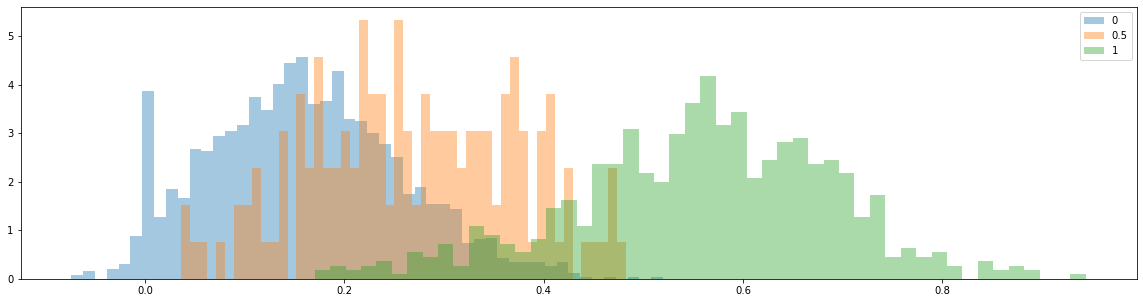

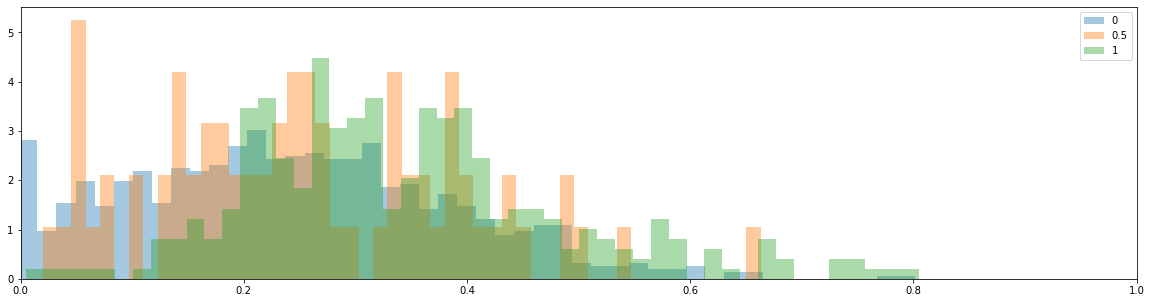

In [ ]:
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.hist(trainPred[train['class'] == c], label=c, alpha=0.4, density=True, bins=50);
plt.legend();
plt.show();
plt.figure(figsize=(20,5))
for c in [0,0.5,1]:
    plt.hist(testPred[test['class'] == c], label=c, alpha=0.4, density=True, bins=50);
plt.legend();
plt.xlim(0,1);
plt.show();

              precision    recall  f1-score   support

         0.0       0.74      0.86      0.80       913
         0.5       0.00      0.00      0.00        74
         1.0       0.40      0.30      0.34       307

    accuracy                           0.68      1294
   macro avg       0.38      0.39      0.38      1294
weighted avg       0.62      0.68      0.64      1294



C:\Users\landrade\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


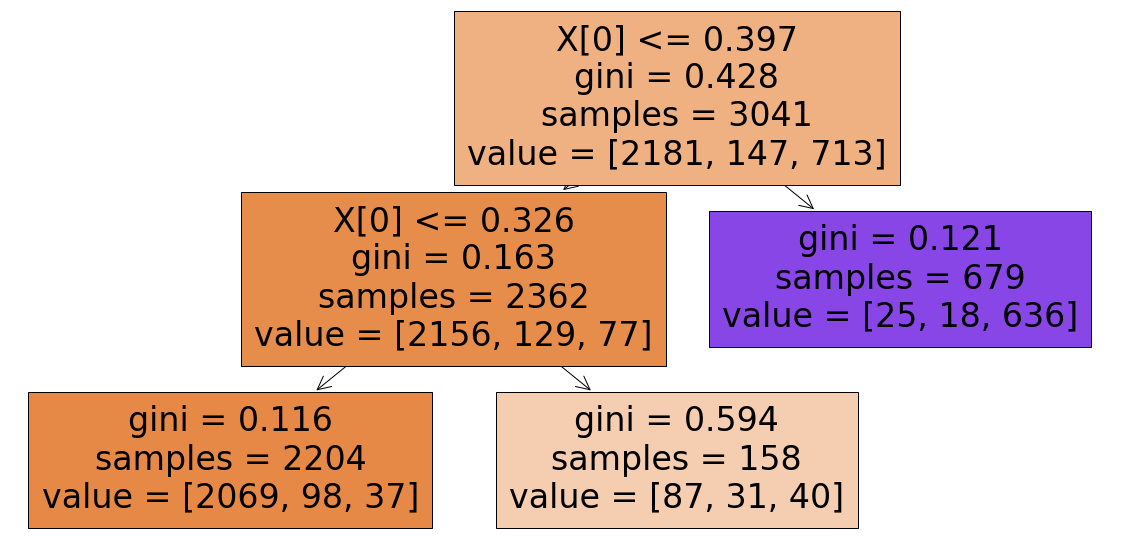

In [ ]:
plt.figure(figsize=(20,10)) 
plot_tree(classifier, filled=True) 
plt.show()

In [ ]:
predicted = resultArray(classifier, test,testPred.reshape(-1,1))

In [ ]:
predicted

{'CIC0009': {'turns': [{'turn-index': 0,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.9286332179930796,
      'prob-T': 0.048875432525951557,
      'prob-X': 0.02249134948096886}]},
   {'turn-index': 2,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.9286332179930796,
      'prob-T': 0.048875432525951557,
      'prob-X': 0.02249134948096886}]},
   {'turn-index': 4,
    'labels': [{'breakdown': 'X',
      'prob-O': 0.2,
      'prob-T': 0.16774193548387098,
      'prob-X': 0.632258064516129}]},
   {'turn-index': 6,
    'labels': [{'breakdown': 'O',
      'prob-O': 0.9286332179930796,
      'prob-T': 0.048875432525951557,
      'prob-X': 0.02249134948096886}]},
   {'turn-index': 8,
    'labels': [{'breakdown': 'X',
      'prob-O': 0.005226480836236934,
      'prob-T': 0.013937282229965157,
      'prob-X': 0.980836236933798}]},
   {'turn-index': 10,
    'labels': [{'breakdown': 'X',
      'prob-O': 0.2,
      'prob-T': 0.16774193548387098,
      'prob-X': 0.632258064516129}]},
 

O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
X,X,10,8
X,O,12,10
O,O,14,12
O,O,16,14
X,O,18,16
O,X,20,18
O,O,1,1
X,X,3,3
O,O,5,5
T,O,7,7
O,X,9,9
O,O,11,11
X,O,13,13
O,O,15,15
O,O,17,17
O,O,19,19
O,O,2,0
O,O,4,2
T,O,6,4
O,O,8,6
X,O,10,8
O,O,12,10
X,O,14,12
T,O,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,X,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,1,1
X,X,3,3
O,O,5,5
X,O,7,7
X,X,9,9
O,O,11,11
X,X,13,13
X,X,15,15
O,X,17,17
O,O,19,19
O,O,1,1
O,O,3,3
X,X,5,5
O,O,7,7
O,O,9,9
O,O,11,11
O,O,13,13
O,X,15,15
O,O,17,17
X,O,19,19
O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
O,O,12,10
X,O,14,12
X,O,16,14
X,O,18,16
X,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,X,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
T,O,20,18
T,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
X,X,12,10
O,O,14,12
X,O,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,X,4,2
X,O,6,4
O,X,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,X,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
X,O,12,10
X,O,14,12
O,O,16,14
O,O,18,16
X,O,20,18
O,

O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
T,O,4,2
O,O,6,4
T,O,8,6
O,O,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
X,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
T,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
T,O,10,8
O,O,12,10
T,O,14,12
O,X,16,14
O,O,18,16
O,O,20,18
O,O,2,0
T,O,4,2
O,O,6,4
X,O,8,6
T,O,10,8
O,O,12,10
O,X,14,12
O,O,16,14
O,O,18,16
T,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
T,O,12,10
O,O,14,12
O,O,16,14
T,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
T,O,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0

{'fileNumber': 123,
 'systemUtterance': 1230,
 'ansO': 850,
 'ansT': 74,
 'ansX': 306,
 'accuracy': 0.6560975609756098,
 'precisionX': 0.38222222222222224,
 'predX_ansX': 86,
 'total_predX': 225,
 'total_ansX': 306,
 'recallX': 0.28104575163398693,
 'f1X': 0.3239171374764595,
 'precisionTX': 0.8888888888888888,
 'recallTX': 0.19665683382497542,
 'f1TX': 0.322061191626409,
 'totalTXAnsX': 200,
 'totalPredX+PredT': 225,
 'totalAnsX': 1017,
 'js-O-T-X': 0.2876077926332945,
 'js-O-T+X': 0.25132921719754103,
 'js-O+T-X': 0.16431924830517416,
 'mse-O-T-X': 0.1679052034665323,
 'mse-O-T+X': 0.2814246964371014,
 'mse-O+T-X': 0.14930165483568208}

In [ ]:
evaluationAsDict(eval_data_path,predicted,0.5)

O,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
X,O,10,8
X,O,12,10
O,X,14,12
O,X,16,14
X,O,18,16
O,O,20,18
O,O,1,1
X,O,3,3
O,X,5,5
T,X,7,7
O,X,9,9
O,X,11,11
X,O,13,13
O,X,15,15
O,X,17,17
O,X,19,19
O,O,2,0
O,O,4,2
T,X,6,4
O,X,8,6
X,X,10,8
O,X,12,10
X,X,14,12
T,O,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,X,4,2
O,X,6,4
O,X,8,6
O,O,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,1,1
X,X,3,3
O,X,5,5
X,O,7,7
X,X,9,9
O,O,11,11
X,X,13,13
X,X,15,15
O,O,17,17
O,X,19,19
O,X,1,1
O,X,3,3
X,X,5,5
O,O,7,7
O,O,9,9
O,O,11,11
O,O,13,13
O,O,15,15
O,O,17,17
X,O,19,19
O,O,2,0
O,X,4,2
O,X,6,4
X,X,8,6
O,O,10,8
O,X,12,10
X,O,14,12
X,O,16,14
X,O,18,16
X,O,20,18
O,O,2,0
O,O,4,2
O,X,6,4
O,X,8,6
O,X,10,8
O,O,12,10
O,X,14,12
O,O,16,14
O,X,18,16
T,O,20,18
T,O,2,0
O,O,4,2
O,O,6,4
X,O,8,6
O,O,10,8
X,O,12,10
O,O,14,12
X,O,16,14
X,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
X,X,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
X,X,18,16
O,O,20,18
O,X,2,0
O,X,4,2
O,X,6,4
X,X,8,6
O,X,10,8
X,O,12,10
X,O,14,12
O,O,16,14
O,O,18,16
X,O,20,18
O,

O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,X,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
X,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,X,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
T,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
T,O,10,8
O,O,12,10
T,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
T,O,4,2
O,O,6,4
X,O,8,6
T,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
T,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
T,O,12,10
O,O,14,12
O,O,16,14
T,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
T,O,10,8
X,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
O,O,14,12
O,O,16,14
O,O,18,16
O,O,20,18
O,O,2,0
O,O,4,2
O,O,6,4
O,O,8,6
O,O,10,8
O,O,12,10
T,O,14,12
O,O,16,14
T,O,18,16
O,O,20,18
######### Data Stats #########
File Num : 		123
System Utterance Num : 	1230
O L

{'fileNumber': 123,
 'systemUtterance': 1230,
 'ansO': 850,
 'ansT': 74,
 'ansX': 306,
 'accuracy': 0.6276422764227643,
 'precisionX': 0.3474025974025974,
 'predX_ansX': 107,
 'total_predX': 308,
 'total_ansX': 306,
 'recallX': 0.34967320261437906,
 'f1X': 0.3485342019543974,
 'precisionTX': 0.8896103896103896,
 'recallTX': 0.2694198623402163,
 'f1TX': 0.41358490566037737,
 'totalTXAnsX': 274,
 'totalPredX+PredT': 308,
 'totalAnsX': 1017,
 'js-O-T-X': 0.2794805132498367,
 'js-O-T+X': 0.23338346884911262,
 'js-O+T-X': 0.1605138388127831,
 'mse-O-T-X': 0.1626205838568687,
 'mse-O-T+X': 0.26386123626734836,
 'mse-O+T-X': 0.1489234592714389}

In [ ]:
pd.DataFrame(classification_report(test['class'].astype(str).values.reshape(-1,1), testPred2.reshape(-1,1),output_dict=True))

,0.0,0.5,1.0,accuracy,macro avg,weighted avg
precision,0.486804,0.294444,0.549165,0.458065,0.443471,0.465910
recall,0.389671,0.352159,0.576998,0.458065,0.439610,0.458065
f1-score,0.432855,0.320726,0.562738,0.458065,0.438773,0.459370
support,426.000000,301.000000,513.000000,0.458065,1240.000000,1240.000000


In [ ]:
classification_report(test['class'].astype(str).values.reshape(-1,1), testPred2.reshape(-1,1),output_dict=True)

{'0.0': {'precision': 0.4868035190615836,
  'recall': 0.38967136150234744,
  'f1-score': 0.43285528031290743,
  'support': 426},
 '0.5': {'precision': 0.29444444444444445,
  'recall': 0.3521594684385382,
  'f1-score': 0.3207261724659607,
  'support': 301},
 '1.0': {'precision': 0.549165120593692,
  'recall': 0.5769980506822612,
  'f1-score': 0.5627376425855514,
  'support': 513},
 'accuracy': 0.45806451612903226,
 'macro avg': {'precision': 0.44347102803324007,
  'recall': 0.43960962687438226,
  'f1-score': 0.4387730317881398,
  'support': 1240},
 'weighted avg': {'precision': 0.46590950303433576,
  'recall': 0.45806451612903226,
  'f1-score': 0.4593704338483392,
  'support': 1240}}

In [ ]:
pipeline.fit(train, train['class'])

[21:32:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('user-utterance-vector',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  ItemSelector(key='user-utterance-tail')),
                                                                 ('W2VecSelector',
                                                                  W2VecSelector(w2v=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000021E829E1278>)),
                                                                 ('pca',
                                                                  PCA(copy=True,
                                                                      iterated_power='auto',
                                                                      n_compon...


In [ ]:
grid = GridSearchCV(pipeline, tuned_parameters, scoring = 'neg_mean_absolute_error', n_jobs= 2)
grid.fit(train, train['class']) 

MemoryError: 

In [ ]:
def convertToClass(array, min, med, max):
    result = []
    for a in array:
        current_class = None
        if a > min and a < med:
            current_class = 'O'
        elif a >= med and a < max:
            current_class = 'T'
        else:
            current_class = 'X'
        result.append(current_class)
    return result
            

In [ ]:
min = -1
med = 0.49
max = 0.51
print(classification_report(convertToClass(np.asarray(test['class']),-1,0.2,0.7), convertToClass(y,min,med,max)))

              precision    recall  f1-score   support

           O       0.76      0.17      0.27       426
           T       0.25      0.93      0.40       301
           X       0.60      0.05      0.09       513

    accuracy                           0.30      1240
   macro avg       0.54      0.38      0.26      1240
weighted avg       0.57      0.30      0.23      1240



In [ ]:
xpto = pipeline.predict_proba(test.iloc[[1]])
#xpto[0][2]
#pipeline.predict(test.iloc[[1]])
test.iloc[1].file_name

AttributeError: 'StackingRegressor' object has no attribute 'predict_proba'

In [ ]:
y = pipeline.predict(test)

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [ ]:
y

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

In [ ]:
print(np.asarray(test['class']))

[0.  0.5 1.  ... 0.  0.5 0.5]


In [ ]:
from sklearn.metrics import r2_score
r2_score(test['class'],y)

0.02874226119785972

(array([358., 336., 222., 160.,  39.,  18.,  13.,   1.,   1.,   2.]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

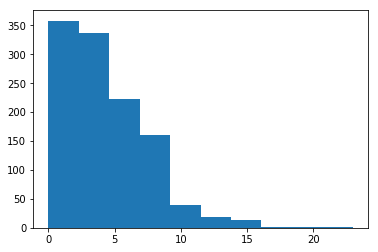

In [ ]:
plt.hist( (  CountVectorizer().fit_transform(train['user-utterance']) >0 ).sum(axis=1))

(array([669., 238., 143.,  47.,  25.,  13.,   5.,   5.,   3.,   2.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

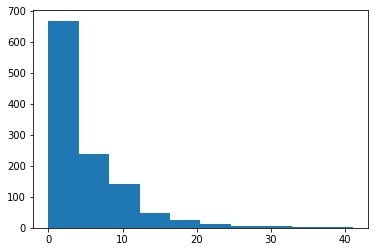

In [ ]:
plt.hist( (  CountVectorizer(binary=True).fit_transform(train['system-utterance']) >0 ).sum(axis=1))

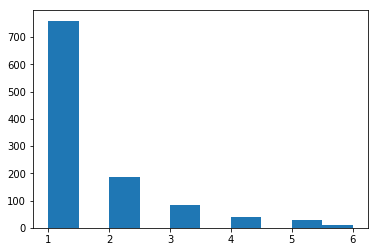

In [ ]:
plt.hist(np.array(CountVectorizer(binary=True,max_df=6).fit_transform(train['user-utterance']).sum(axis=0))[0]);